# **Insights de dados de texto com NLP**
## Modelagem de tópicos, extração de keywords e recomendação de artigos
&nbsp;

Alguns recursos possibilitam acesso eficiente à informação e leitura rápida da abordagem de um texto. O objetivo desse estudo é propiciar acesso à informação focado aplicando técnicas de NLP em um banco de artigos. Para tal, o estudo foi separado em diferentes etapas:     

1. Classificação de artigos por tópicos
2. Extração de palavras chaves de um artigo
3. Recomendação artigos relacionados


&nbsp;

<u> Sobre o dataset: </u>

O conjunto de dados original nomeado "NIPS Paper" é do Kaggle, disponível pelo link:

https://www.kaggle.com/datasets/benhamner/nips-papers?resource=download&select=paper_authors.csv  


O Neural Information Processing Systems (NIPS) é uma das principais conferências de Machine Learning mundiais. 
O dataset contém os títulos, resumos, textos completos e anos de todos os artigos do NIPS publicados de 1987 a 2017. Ao todo são 7240 artigos.

Uma vez que o intuito é compreender o conceito das técnica e usar o texto completo do artigo para modelagem NLP poderia ser computacionalmente demandante, foram utilizados apenas 3500 caracteres de cada texto. Vale ressaltar que o mesmo código pode ser utilizado nos textos completos para aprimorar os modelos.

&nbsp;

&nbsp;
### **Instalando as bibliotecas externas**

In [1]:
# Biblioteca de processamento de texto
!pip install spacy

# Instalando o core inglês
!python -m spacy download en

# Para visualização gráfica
!pip install plotly

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


&nbsp;
### **Carregando os pacotes**

In [2]:
%matplotlib inline
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
import re
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import plotly.express as px

# Text cleaning
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

# Modelagem de tópicos
from sklearn.decomposition import NMF

# Extração de keywords
from sklearn.feature_extraction.text import TfidfTransformer
from collections import Counter

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


&nbsp;
### **Obtendo e conhecendo os dados**

In [4]:
papers = pd.read_csv('papers.csv')

In [5]:
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [6]:
papers.shape

(7241, 7)

In [7]:
papers.isnull().sum()

id               0
year             0
title            0
event_type    4819
pdf_name         0
abstract         0
paper_text       0
dtype: int64

In [8]:
print(f'Número de observações duplicadas: {papers.duplicated().sum()}')

Número de observações duplicadas: 0


In [9]:
# Verificando os tipos de eventos 
papers.event_type.unique()

array([nan, 'Oral', 'Spotlight', 'Poster'], dtype=object)

In [10]:
# Contando as ocorrências de "Abstract Missing" na coluna abstract
print(f"Há {papers.abstract.value_counts()['Abstract Missing']} resumos não indicados.")

Há 3317 resumos não indicados.


In [11]:
# Acenssando os artigos que possuem Abstract
papers_including_abstract = papers[papers['abstract'] != 'Abstract Missing']
papers_including_abstract.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
941,1861,2000,Algorithms for Non-negative Matrix Factorization,NaN,1861-algorithms-for-non-negative-matrix-factor...,Non-negative matrix factorization (NMF) has pr...,Algorithms for Non-negative Matrix\nFactorizat...
1067,1975,2001,Characterizing Neural Gain Control using Spike...,NaN,1975-characterizing-neural-gain-control-using-...,Spike-triggered averaging techniques are effec...,Characterizing neural gain control using\nspik...
2384,3163,2007,Competition Adds Complexity,NaN,3163-competition-adds-complexity.pdf,It is known that determinining whether a DEC-P...,Competition adds complexity\n\nJudy Goldsmith\...
2385,3164,2007,Efficient Principled Learning of Thin Junction...,NaN,3164-efficient-principled-learning-of-thin-jun...,We present the first truly polynomial algorith...,Efficient Principled Learning of Thin Junction...
2388,3167,2007,Regularized Boost for Semi-Supervised Learning,NaN,3167-regularized-boost-for-semi-supervised-lea...,Semi-supervised inductive learning concerns ho...,Regularized Boost for Semi-Supervised Learning...


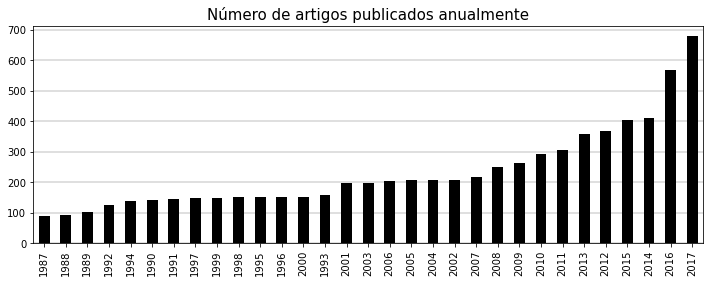

In [12]:
# Visualizando a frequência anual de publicações 

papers['year'].value_counts().sort_values().plot(kind = 'bar', color = "black", figsize=(12, 4))

plt.title("Número de artigos publicados anualmente", size=15)
plt.grid(axis='y', linewidth=0.25, color='black')

plt.show();

&nbsp;
### **Data cleaning**

In [13]:
# Eliminando a coluna 'pdf_name' que contém informações redundantes
# E, eliminando a coluna 'event_type' que possui muitos valores faltantes

papers = papers.drop(['event_type', 'pdf_name'], axis=1)

&nbsp;
### **Text cleaning**

Aqui, será realizada a limpeza dos textos do artigos (coluna paper_text). Para isso será necessário obter a lista de stopwords.

In [14]:
# Carregando o core do idioma inglês da biblioteca spaCy
nlp = spacy.load('en_core_web_sm')

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords = set(stopwords) # Covertendo seu formato de 'list' para 'set' (coleção de elemntos) 

# Agregando palavras genéricas tipicamente encontradas em artigos à lista de stopwords
typical_generic_words = ["figure","fig", "table", "tab", "x", "sample", "problem", "approach", "task", "use", "parameter", "propose",
                         "using", "also", "show", "result", "based", "new", "provide", "previously", "solution","one","two"]

stopwords = list(stopwords.union(typical_generic_words))

In [16]:
# Acessando o texto do primeiro artigo, apenas os 1000 caracteres iniciais
papers['paper_text'][0][:1000]

'767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABASE\nAND ITS APPLICATIONS\nHisashi Suzuki and Suguru Arimoto\nOsaka University, Toyonaka, Osaka 560, Japan\nABSTRACT\nAn efficient method of self-organizing associative databases is proposed together with\napplications to robot eyesight systems. The proposed databases can associate any input\nwith some output. In the first half part of discussion, an algorithm of self-organization is\nproposed. From an aspect of hardware, it produces a new style of neural network. In the\nlatter half part, an applicability to handwritten letter recognition and that to an autonomous\nmobile robot system are demonstrated.\n\nINTRODUCTION\nLet a mapping f : X -+ Y be given. Here, X is a finite or infinite set, and Y is another\nfinite or infinite set. A learning machine observes any set of pairs (x, y) sampled randomly\nfrom X x Y. (X x Y means the Cartesian product of X and Y.) And, it computes some\nestimate j : X -+ Y of f to make small, the estimation erro

In [17]:
# Realizando a limpeza dos textos do artigos 
# Optou-se por analisar 3500 caracteres de cada texto  

corpus = []

for i in range (0, len(papers)):
    text = papers['paper_text'][i][:3500]

    text = text.lower() # Caixa baixa

    text = re.sub(' +', ' ', text) # Remoção de multiplos espaçamentos

    doc = nlp(text) # Tokenização
    
    tokens = [token.text for token in doc if token.text not in stopwords] # Elimina stopwords
    tokens = [word for word in tokens if word.isalpha()] # Mantém somente tokens alfabéticos 
    tokens = [word for word in tokens if len(word) >= 3] # Remove palavras de uma ou duas letras
    
    
    #Lematização    
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(word) for word in tokens]


    text= " ".join(tokens)
    corpus.append(text)

In [18]:
# Verificando o texto do primeiro artigos
# Após text cleaning
corpus[0][:1000]

'self organization associative database application hisashi suzuki suguru arimoto osaka university toyonaka osaka japan abstract efficient method self organizing associative database proposed together application robot eyesight system proposed database associate input output first half part discussion algorithm self organization proposed aspect hardware produce style neural network latter half part applicability handwritten letter recognition autonomous mobile robot system demonstrated introduction let mapping given finite infinite set another finite infinite set learning machine observes set pair sampled randomly mean cartesian product computes estimate make small estimation error measure usually say faster decrease estimation error increase number sample better learning machine however expression performance incomplete since lack consideration candidate assumed preliminarily find good learning machine clarify conception let discus type learning machine let advance understanding self 

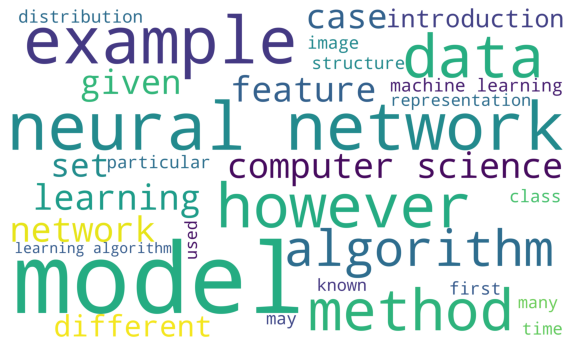

In [55]:
# Plotando a wordcloud das palavras mais frequentes no corpus

plt.figure(figsize=(10,15))

wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=30, width=3000, height=1800).generate(str(corpus))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [21]:
# Adicionando os textos tratados ao dataset
papers['paper_text']=corpus
papers.head()

,id,year,title,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,Abstract Missing,self organization associative database applica...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,mean field theory layer visual cortex applicat...
2,100,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,storing covariance associative potentiation de...
3,1000,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,bayesian query construction neural network mod...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,neural network ensemble cross validation activ...


&nbsp;
## Vetorizador de texto TF-IDF
---

TF-IDF (Term Frequency - Inverse Document Frequency) são pontuações de frequência de palavras que destaca as palavras por sua importantância para o contexto, ao invés de considerar apenas sua frequência. 

Contagens elevadas de palavras genéricas reduz o impacto de palavras específicas de um contexto. Então, além de considerar a frequência de um termo (TF), também devemos considerar a importância dele num conjunto de documentos (“corpus”). Na frequência de documentos inversa (IDF), as palavras não muito usadas têm mais peso do que as palavras muito usadas numa coleção de documentos.

Em outras palavras, na TF-IDF, a palavra muito usada em um documento e pouco frequente nos demais documentos, adquire maior importância.

&nbsp;

In [22]:
# Nesse caso, o TF-IDF exige que cada termo apareça pelo menos 2 (min_df = 2) vezes, 
# mas não com maior frequência do que em 80% (max_df=0,8) dos documentos.
# O modelo treinado contém os principais unigrams e bigrams encontrados no corpus
vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                     min_df=2,
                     max_df=0.8,
                     stop_words=stopwords)


tfidf_matrix = vectorizer.fit_transform(papers['paper_text'])

In [23]:
# Criando uma variável com os nomes das features
feature_names = vectorizer.get_feature_names()

&nbsp;
## Modelagem de tópicos
---

In [24]:
# Treinando um modelo que obtém 7 tópicos de abordagem dos artigos  
nmf_model = NMF(n_components=7, random_state=42)

nmf_model.fit(tfidf_matrix)

c:\Users\maria\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=7, random_state=42)

In [25]:
# Imprimindo as 15 principais palavras de cada tópico
for index, topic in enumerate(nmf_model.components_):
    print(f'As 15 principais palavras do tópico #{index}:')
    print([feature_names[i] for i in topic.argsort()[-15:]])
    print('\n')

As 15 principais palavras do tópico #0:
['rank', 'set', 'gradient', 'label', 'bound', 'method', 'optimization', 'loss', 'clustering', 'convex', 'function', 'data', 'learning', 'matrix', 'algorithm']


As 15 principais palavras do tópico #1:
['system', 'deep', 'hidden', 'recurrent', 'architecture', 'learning', 'output', 'training', 'weight', 'layer', 'input', 'unit', 'neural', 'neural network', 'network']


As 15 principais palavras do tópico #2:
['control', 'game', 'function', 'algorithm', 'value function', 'value', 'decision', 'learning', 'reinforcement learning', 'reinforcement', 'agent', 'state', 'reward', 'action', 'policy']


As 15 principais palavras do tópico #3:
['segmentation', 'vision', 'pixel', 'motion', 'face', 'detection', 'human', 'representation', 'model', 'recognition', 'scene', 'visual', 'feature', 'object', 'image']


As 15 principais palavras do tópico #4:
['probabilistic', 'graphical model', 'process', 'graphical', 'posterior', 'mixture', 'gaussian', 'variational', 

In [26]:
topic_results = nmf_model.transform(tfidf_matrix)

papers['Topic'] = topic_results.argmax(axis=1)

In [27]:
remap = {0:'Optimization', 1:'Deep Learning', 2:'Reinforcement Learning', 3:'Image Recognition', 4:'Gaussian Process', 5:'Theory of Neural Networks', 6:'Classification' }

papers.replace({'Topic': remap}, inplace=True)
papers.head()

,id,year,title,abstract,paper_text,Topic
0,1,1987,Self-Organization of Associative Database and ...,Abstract Missing,self organization associative database applica...,Deep Learning
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,mean field theory layer visual cortex applicat...,Theory of Neural Networks
2,100,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,storing covariance associative potentiation de...,Theory of Neural Networks
3,1000,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,bayesian query construction neural network mod...,Gaussian Process
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,neural network ensemble cross validation activ...,Deep Learning


&nbsp;
### **Visualizando as informações obtidas**

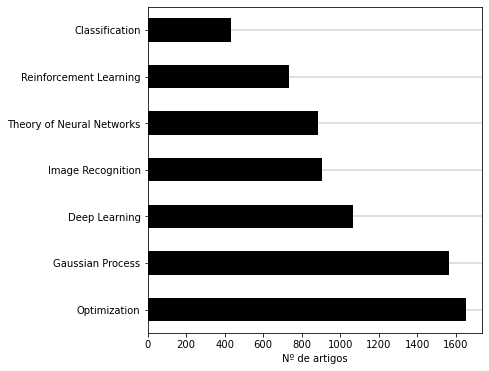

In [28]:
# Frequência de artigos por tópicos 

papers['Topic'].value_counts().plot(kind = 'barh', color = "black", figsize=(6, 6))

plt.grid(axis='y', linewidth=0.25, color='black')
plt.xlabel('Nº de artigos')

plt.show();

In [29]:
# Criando um dataframe com o número de artigos publicados por tópico anualmente
timeline = papers.groupby(['year', 'Topic']).size().reset_index()
timeline.head()

,year,Topic,0
0,1987,Deep Learning,58
1,1987,Image Recognition,4
2,1987,Reinforcement Learning,2
3,1987,Theory of Neural Networks,26
4,1988,Deep Learning,61


In [30]:
timeline = timeline.rename(columns={0:'ocorrencias'})

In [31]:
fig = px.bar(timeline, x='year', y='ocorrencias', color='Topic',
            labels={'year':'Ano', 'ocorrencias':''}, title='Número de artigos publicados anualmente', template='plotly_white')

fig.show()

Após plotar um gráfico interativo por meio da biblioteca Plotly, gostaria de obter esse gráfico como uma imagem estática. Para isso, ele foi convertido em html e salvo no próprio repositório. E então, ao abrir o arquivo, o pequeno ícone de câmera na parte superior direita do html possibilitou efetuar o download do gráfico como png.

In [38]:
# Salvando o gráfico iterativo em formato html no próprio repositório 
fig.write_html("fig.html")

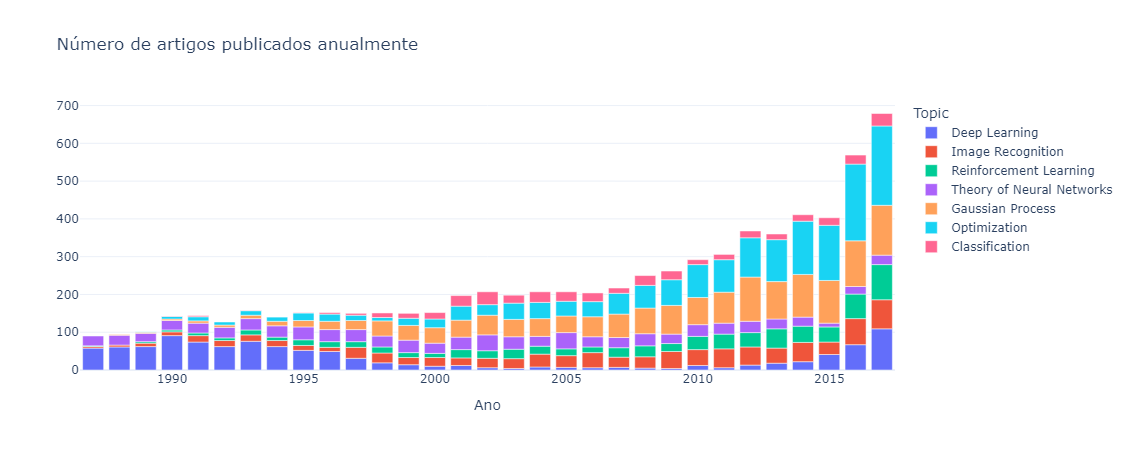

In [39]:
# Apenas exibindo a imagem estática do gráfico 
from PIL import Image
Image.open('newplot.png')

&nbsp;
## Extração de keywords
---

In [40]:
# Treinando um modelo
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(tfidf_matrix)

# Por exemplo, aqui o modelo é aplicado no artigo de índice 10
# O mesmo será feito posteriormente englobando todos os artigos
doc = papers.paper_text[10]

tf_idf_doc = tfidf_transformer.transform(vectorizer.transform([doc]))

In [41]:
from scipy.sparse import coo_matrix

# Função que classifica o TF-IDF de cada artigo em ordem descrescente   
# Seu input é uma matriz de coordenadas 
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data) 
    return sorted(tuples, key=lambda x:(x[1], x[0]), reverse=True)



# Função para obter as n principais keywords e seus TF-IDF scores, por default n=10
def extract_keywords_from_vector(feature_names, sorted_items, topn=10):
    
    # Esse input refere-se ao topn TF-IDF de um artigo em ordem decrescente
    # Resultante da aplicação da função anterior, sort_coo()
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # Buscando a palavra e o TF-IDF score
    for idx, score in sorted_items:
        score_vals.append(round(score, 2))
        feature_vals.append(feature_names[idx])
 
    #Cria tupla de keywords (feature) e TF-IDF score
    results= {}
    for idx in range(0, len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [42]:
# Aplicando o modelo e as funções em cada um dos artigos
keywords_corpus = []

for i in range (0, len(papers)):
    doc = papers.paper_text[i] # Busca o texto de um artido de índice t
    tf_idf_doc = tfidf_transformer.transform(vectorizer.transform([doc]))

    tf_idf_coo_matrix = tf_idf_doc.tocoo() # Converte a matriz esparsa TF-IDF em formato de coordenadas 
    sorted_items=sort_coo(tf_idf_coo_matrix) # Classifica o TF-IDF em ordem descrescente

    # Cria uma tupla de keywords (feature) e TF-IDF score desse artigo
    keywords_doc=extract_keywords_from_vector(feature_names, sorted_items, 5)

    # Adiciona a nova tupla gerada à lista de tuplas
    keywords_corpus.append(keywords_doc)

In [43]:
# Extraindo as palavras-chave e seus scores do dicionário 'keywords_corpus'
keywords_with_scores = []

for i in range (0,len(keywords_corpus)):
        keywords_doc = str(keywords_corpus[i])
        
        # Text cleaning
        keywords_doc=keywords_doc.title().replace('{','').replace("'",'').replace('}','')
        
        keywords_with_scores.append(keywords_doc)

In [44]:
keywords_scores = pd.DataFrame(keywords_with_scores)
keywords_scores.head()

,0
0,"Learning Machine: 0.35, Organization Associati..."
1,"Cell: 0.22, Cell Network: 0.2, Cortical Synaps..."
2,"Ltp: 0.35, Synaptic Strength: 0.3, Steward: 0...."
3,"Decision Theoretic: 0.18, Query: 0.17, Gerhard..."
4,"Ensemble: 0.34, Ambiguity: 0.17, Network Ensem..."


In [45]:
papers['Keywords with scores'] = keywords_with_scores
papers.head()

,id,year,title,abstract,paper_text,Topic,Keywords with scores
0,1,1987,Self-Organization of Associative Database and ...,Abstract Missing,self organization associative database applica...,Deep Learning,"Learning Machine: 0.35, Organization Associati..."
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,mean field theory layer visual cortex applicat...,Theory of Neural Networks,"Cell: 0.22, Cell Network: 0.2, Cortical Synaps..."
2,100,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,storing covariance associative potentiation de...,Theory of Neural Networks,"Ltp: 0.35, Synaptic Strength: 0.3, Steward: 0...."
3,1000,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,bayesian query construction neural network mod...,Gaussian Process,"Decision Theoretic: 0.18, Query: 0.17, Gerhard..."
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,neural network ensemble cross validation activ...,Deep Learning,"Ensemble: 0.34, Ambiguity: 0.17, Network Ensem..."


In [46]:
# Obtendo somente as palavras-chave
# Obtendo as informações do dicionário 'keywords_corpus'
keywords_without_scores = []

for i in range (0,len(papers)):
        keywords_clean = (papers['Keywords with scores'][i])
        
        # Text cleaning
        keywords_clean=re.sub(r': \d.\d\d', '', keywords_clean)
        keywords_clean=re.sub(r': \d.\d', '', keywords_clean)

        keywords_without_scores.append(keywords_clean)

In [47]:
keywords_without_scores = pd.DataFrame(keywords_without_scores)
papers['Keywords']=keywords_without_scores
papers.head()

,id,year,title,abstract,paper_text,Topic,Keywords with scores,Keywords
0,1,1987,Self-Organization of Associative Database and ...,Abstract Missing,self organization associative database applica...,Deep Learning,"Learning Machine: 0.35, Organization Associati...","Learning Machine, Organization Associative, Fi..."
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,mean field theory layer visual cortex applicat...,Theory of Neural Networks,"Cell: 0.22, Cell Network: 0.2, Cortical Synaps...","Cell, Cell Network, Cortical Synapsis, Respons..."
2,100,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,storing covariance associative potentiation de...,Theory of Neural Networks,"Ltp: 0.35, Synaptic Strength: 0.3, Steward: 0....","Ltp, Synaptic Strength, Steward, Levy Steward,..."
3,1000,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,bayesian query construction neural network mod...,Gaussian Process,"Decision Theoretic: 0.18, Query: 0.17, Gerhard...","Decision Theoretic, Query, Gerhard Paass, Plut..."
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,neural network ensemble cross validation activ...,Deep Learning,"Ensemble: 0.34, Ambiguity: 0.17, Network Ensem...","Ensemble, Ambiguity, Network Ensemble, Jesper,..."


&nbsp;
## Modelagem de recomendação
---

In [48]:
# Obtendo a matriz de similaridade de coseno
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

In [49]:
# Construindo uma lista de consulta de índice pelo título do artigo
indices = pd.Series(papers.index, index=papers['title']).drop_duplicates()

In [50]:
def get_recomendation(title, cosine_sim = cosine_sim):
    # Obtendo o índice referente ao título
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores,key =lambda x:x[1],reverse= True )
    
    
    sim_scores = sim_scores[1:11]
    
    # Obtendo os índices dos artigos 
    papers_indices = [i[0] for i in sim_scores]
    
    # Retorna os 10 artigos mais similares
    return papers[['year','title', 'Topic', 'Keywords']].iloc[papers_indices]

&nbsp;
### **Exemplo de aplicação do modelo**

Para exemplificar, aplicou-se a modelagem de recomendação em um artigo.

In [51]:
# Consultando o título do artigo cujo índice no dataframe é 10
papers.title[10]

'Learning to Play the Game of Chess'

In [52]:
# Acessando mais informações sobre a observação de índice 10 do dataframe
papers[['year','title','Topic']].iloc[[10]]

,year,title,Topic
10,1994,Learning to Play the Game of Chess,Deep Learning


In [53]:
# Formatação para que a exibição das informações do dataframe seja completa (não truncadas)
pd.set_option('display.max_colwidth', None)

In [54]:
# Aplicando o modelo em um exemplo
# Nesse caso, obteremos os 10 artigos mais recomendados pelo modelo, tendo como referência o artigo de índice 10
# Na triagem, o modelo analisou todos os 7240 artigos do dataset

get_recomendation('Learning to Play the Game of Chess', cosine_sim)

,year,title,Topic,Keywords
7048,1993,Temporal Difference Learning of Position Evaluation in the Game of Go,Reinforcement Learning,"Position Evaluation, Board, Game, Computer Chess, Board Position"
2307,2006,A Scalable Machine Learning Approach to Go,Reinforcement Learning,"Board, Across Board, Game, Unique Opportunity, Propensity Local"
2361,2006,An Approach to Bounded Rationality,Reinforcement Learning,"Game, Bounded Rationality, Player, Strategy Cost, Rationality"
320,1996,Why did TD-Gammon Work?,Reinforcement Learning,"Gammon, Tesauro, Backgammon, Self Play, Propagation Reinforcement"
3004,2009,Bootstrapping from Game Tree Search,Reinforcement Learning,"Nsw, Chess, Search, Search Depth, Alpha Beta"
2203,1987,A 'Neural' Network that Learns to Play Backgammon,Deep Learning,"Backgammon, Board Game, Scaling Generalization, Issue Network, Game"
1858,2004,Modelling Uncertainty in the Game of Go,Reinforcement Learning,"Stone, Board, Territory, Game, Game Tree"
5680,1992,Explanation-Based Neural Network Learning for Robot Control,Deep Learning,"Ebnn, Domain Theory, Robot Control, Observed Training, Robot"
6269,2017,Safe and Nested Subgame Solving for Imperfect-Information Games,Reinforcement Learning,"Subgame, Information Game, Game, Imperfect Information, Subgames"
2290,2006,TrueSkill?: A Bayesian Skill Rating System,Gaussian Process,"Elo, Rating System, Skill, Rating, Skill Rating"
